In [19]:
from field_util import Field, CartCoord
from vis_util import texture_opacity

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
import numpy as np
from scipy import ndimage
import copy
from matplotlib.colors import LogNorm as LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import os

from matplotlib.backends.backend_pdf import PdfPages

In [20]:
import matplotlib as mpl

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

#cosmetics
mpl.rc('text', usetex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 23
})

In [3]:
data_path = '../Data/'
plot_path = '../Plot/'

In [4]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original
mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth

In [5]:
# read data
os.listdir(data_path+"rec_field_sim/")
rec_sim_list = [data_path+'rec_field_sim/'+fn for fn in os.listdir(data_path+"rec_field_sim/") if fn[-3:]=='bin']

In [6]:
R_tophat = 4 * u.Mpc

# clamato
clamato_path = '../Data/CLAMATO/map_2020_v0.bin'
delta_clm_real = np.fromfile(clamato_path, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_clm_real = delta_clm_real[::1,::-1,::1] 
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
CLAMATO_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_clm_real)
res = CLAMATO_field.smooth_tophat_fft(R_tophat)


# mock
mock_field_list = []
for i, fn in enumerate(rec_sim_list):
    delta_rec_mock = np.fromfile(fn, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
    delta_rec_mock = delta_rec_mock[::1,::-1,::1] 

    x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
    rec_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec_mock)
    res = rec_field.smooth_tophat_fft(R_tophat)

    mock_field_list.append(rec_field)

# takes ~ 6 / 25 min to convolve !!! (for convolve in real space, ~ 50 / 200realizations)
# 20 / 100 sec with FFT (expected)

In [7]:
COSTCO_meta = pd.read_csv('../Catalogs/COSTCO_metadata.csv')
COSTCO_selection = COSTCO_meta.iloc[[3, 4, 5, 6, 10, 8, 9, 0, 12]]

In [8]:
def sph_mask(field, center, radius):
    x_c, y_c, z_c = center
    s = field.field_data.shape
    grid = np.array(np.meshgrid(np.arange(s[0]), np.arange(s[1]), np.arange(s[2]), indexing='ij'))
    grid_coord = field.index2coord(grid[0], grid[1], grid[2])
    mask_sph = ((grid_coord[0]- x_c)**2+ (grid_coord[1]- y_c)**2+(grid_coord[2]- z_c)**2) < radius**2
    return mask_sph

In [9]:
radius = 15*u.Mpc
sim_list = []
cla_list = []
for gal in COSTCO_selection.iloc:
    c = mycoord.orig_to_box(gal['RA'], gal['DE'], gal['z_obs'])
    m = sph_mask(CLAMATO_field, c, radius)
    sim_mean_list = []
    for r in mock_field_list:
        data = copy.deepcopy(r.field_data)
        data[~m] = np.nan
        avg = np.nanmean(data)
        sim_mean_list.append(avg)
    data = copy.deepcopy(CLAMATO_field.field_data)
    data[~m] = np.nan
    avg = np.nanmean(data)
    
    sim_list.append(sim_mean_list)
    cla_list.append(avg)

In [13]:
np.sum(np.array(sim_list)[4] < cla_list[4])

228

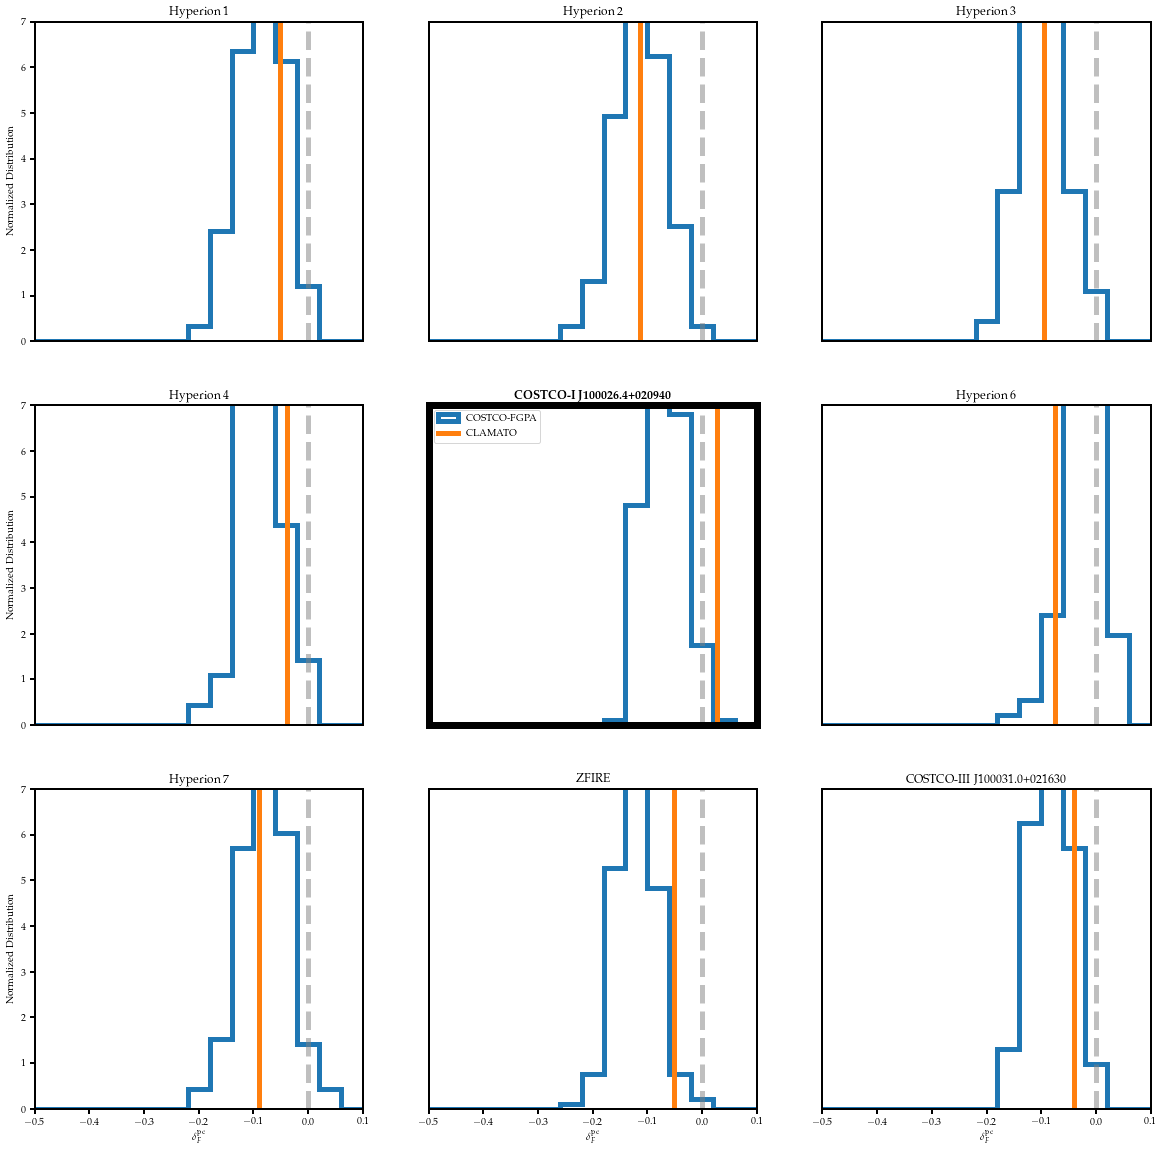

In [10]:
f = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(20, 20)

for i in range(3):
    for j in range(3):
        index = i*3 + j
        pc = COSTCO_selection.iloc[index]
        

        MOCK = sim_list[index]
        REAL = cla_list[index]

        plt.subplot(grid[7*i:7*i+6, 7*j:7*j+6])

        plt.hist(MOCK, bins = 15, histtype='step', linewidth = 5, density=True, label = 'COSTCO-FGPA', range = (-0.5, 0.1))
        plt.plot([REAL, REAL], [0, 10],  linewidth = 5,  label = 'CLAMATO')
        plt.plot([0, 0], [0, 10],  linewidth = 5,  c = "Grey", alpha = 0.5, linestyle = '--')
        if i == 2:
            plt.xlabel("$\\delta_F^{\mathrm{pc}}$")
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel("Normalized Distribution")
        else:
            plt.yticks([])
        if i == 1 and j == 1:
            plt.legend()
            plt.title("\\textbf{"+pc['Name']+"}")

            bwith = 7
            ax = plt.gca()
            ax.spines['bottom'].set_linewidth(bwith)
            ax.spines['left'].set_linewidth(bwith)
            ax.spines['top'].set_linewidth(bwith)
            ax.spines['right'].set_linewidth(bwith)
            
        else:
            plt.title(pc["Name"])
        plt.xlim(-0.5, 0.1)
        plt.ylim(0, 7)
assert radius == 15*u.Mpc
pdf_pages = PdfPages('Detection_Multi_panel_15Mpc.pdf')
pdf_pages.savefig(f, pad_inches = 0)
pdf_pages.close()

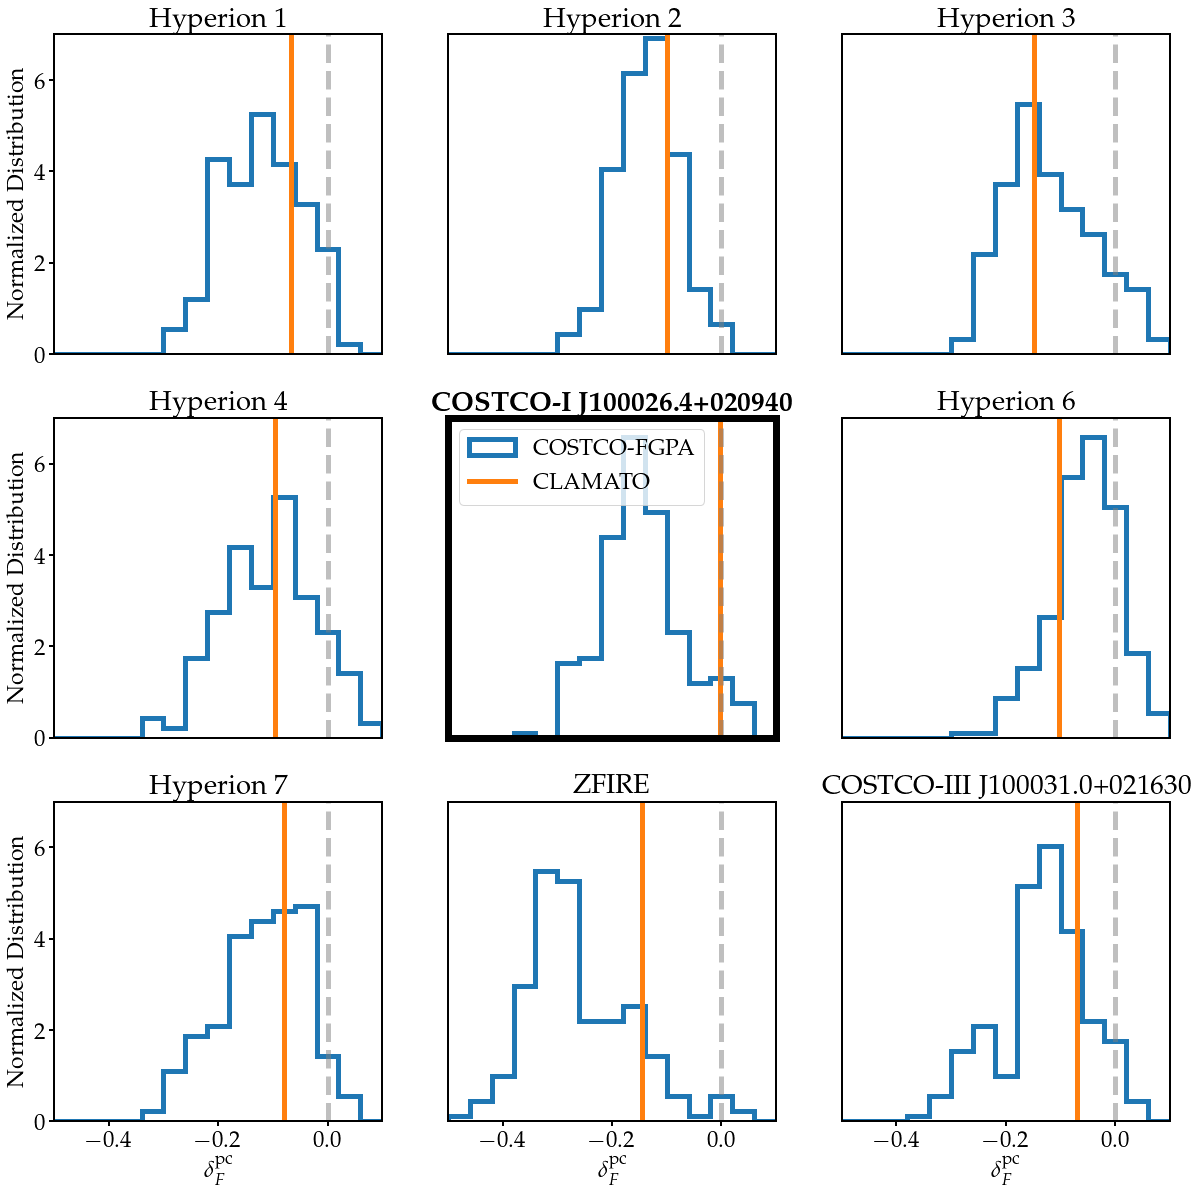

In [40]:
f = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(20, 20)

for i in range(3):
    for j in range(3):
        index = i*3 + j
        pc = COSTCO_selection.iloc[index]
        

        MOCK = sim_list[index]
        REAL = cla_list[index]

        plt.subplot(grid[7*i:7*i+6, 7*j:7*j+6])

        plt.hist(MOCK, bins = 15, histtype='step', linewidth = 5, density=True, label = 'COSTCO-FGPA', range = (-0.5, 0.1))
        plt.plot([REAL, REAL], [0, 10],  linewidth = 5,  label = 'CLAMATO')
        plt.plot([0, 0], [0, 10],  linewidth = 5,  c = "Grey", alpha = 0.5, linestyle = '--')
        if i == 2:
            plt.xlabel("$\\delta_F^{\mathrm{pc}}$")
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel("Normalized Distribution")
        else:
            plt.yticks([])
        if i == 1 and j == 1:
            plt.legend()
            plt.title("\\textbf{"+pc['Name']+"}")

            bwith = 7
            ax = plt.gca()
            ax.spines['bottom'].set_linewidth(bwith)
            ax.spines['left'].set_linewidth(bwith)
            ax.spines['top'].set_linewidth(bwith)
            ax.spines['right'].set_linewidth(bwith)
            
        else:
            plt.title(pc["Name"])
        plt.xlim(-0.5, 0.1)
        plt.ylim(0, 7)
assert radius == 7.5*u.Mpc
pdf_pages = PdfPages('Detection_Multi_panel_7_5Mpc.pdf')
pdf_pages.savefig(f, pad_inches = 0)
pdf_pages.close()

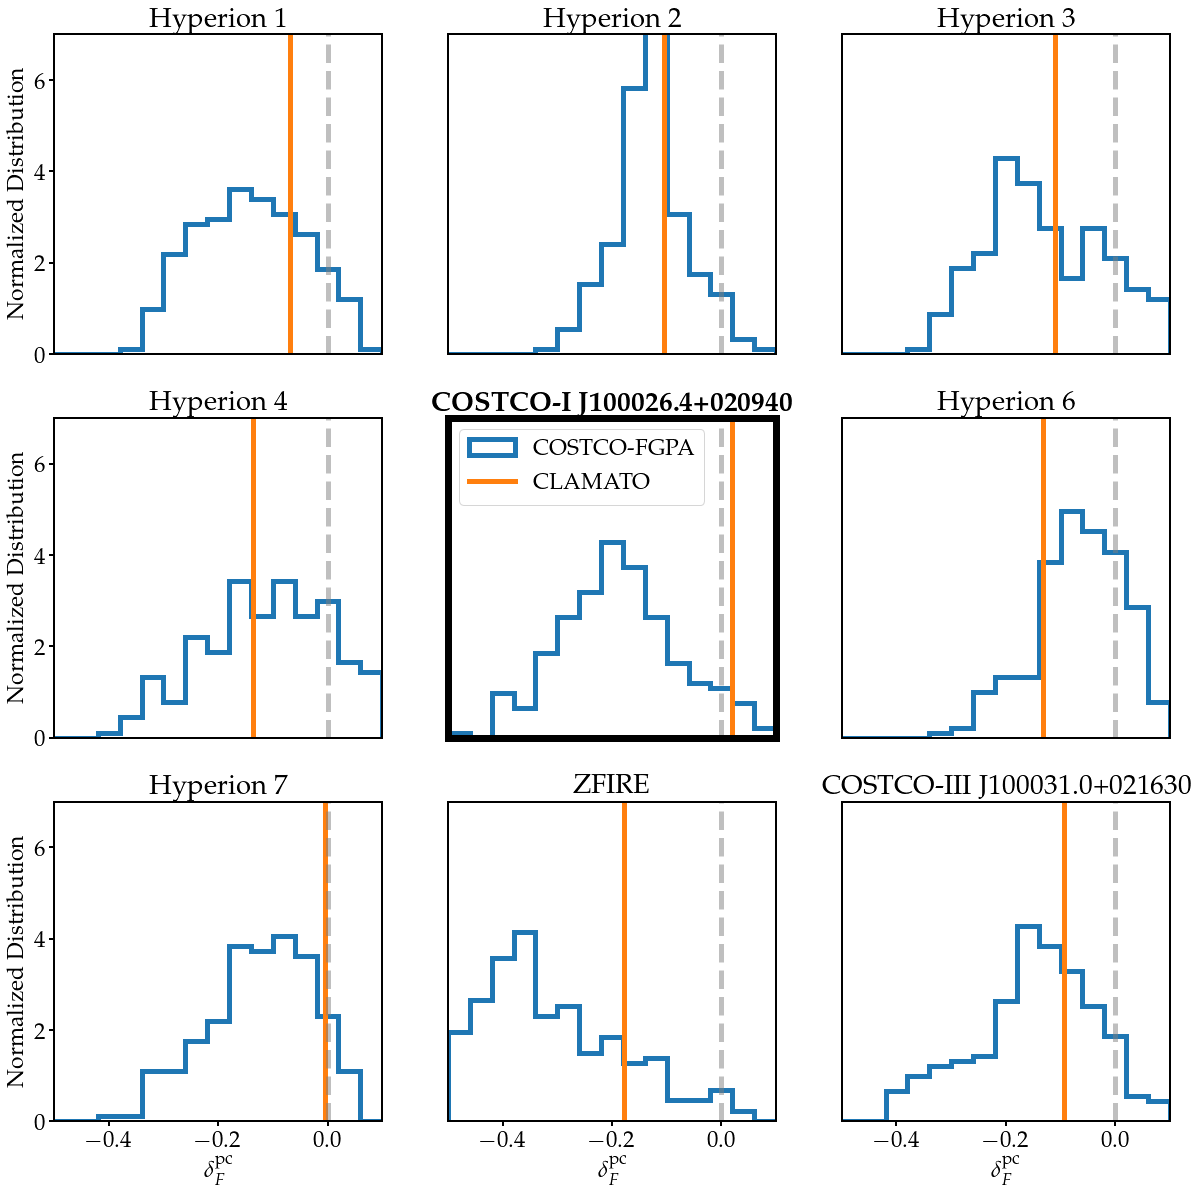

In [43]:
f = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(20, 20)

for i in range(3):
    for j in range(3):
        index = i*3 + j
        pc = COSTCO_selection.iloc[index]
        

        MOCK = sim_list[index]
        REAL = cla_list[index]

        plt.subplot(grid[7*i:7*i+6, 7*j:7*j+6])

        plt.hist(MOCK, bins = 15, histtype='step', linewidth = 5, density=True, label = 'COSTCO-FGPA', range = (-0.5, 0.1))
        plt.plot([REAL, REAL], [0, 10],  linewidth = 5,  label = 'CLAMATO')
        plt.plot([0, 0], [0, 10],  linewidth = 5,  c = "Grey", alpha = 0.5, linestyle = '--')
        if i == 2:
            plt.xlabel("$\\delta_F^{\mathrm{pc}}$")
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel("Normalized Distribution")
        else:
            plt.yticks([])
        if i == 1 and j == 1:
            plt.legend()
            plt.title("\\textbf{"+pc['Name']+"}")

            bwith = 7
            ax = plt.gca()
            ax.spines['bottom'].set_linewidth(bwith)
            ax.spines['left'].set_linewidth(bwith)
            ax.spines['top'].set_linewidth(bwith)
            ax.spines['right'].set_linewidth(bwith)
            
        else:
            plt.title(pc["Name"])
        plt.xlim(-0.5, 0.1)
        plt.ylim(0, 7)
assert radius == 4.5*u.Mpc
pdf_pages = PdfPages('Detection_Multi_panel_4_5Mpc.pdf')
pdf_pages.savefig(f, pad_inches = 0)
pdf_pages.close()

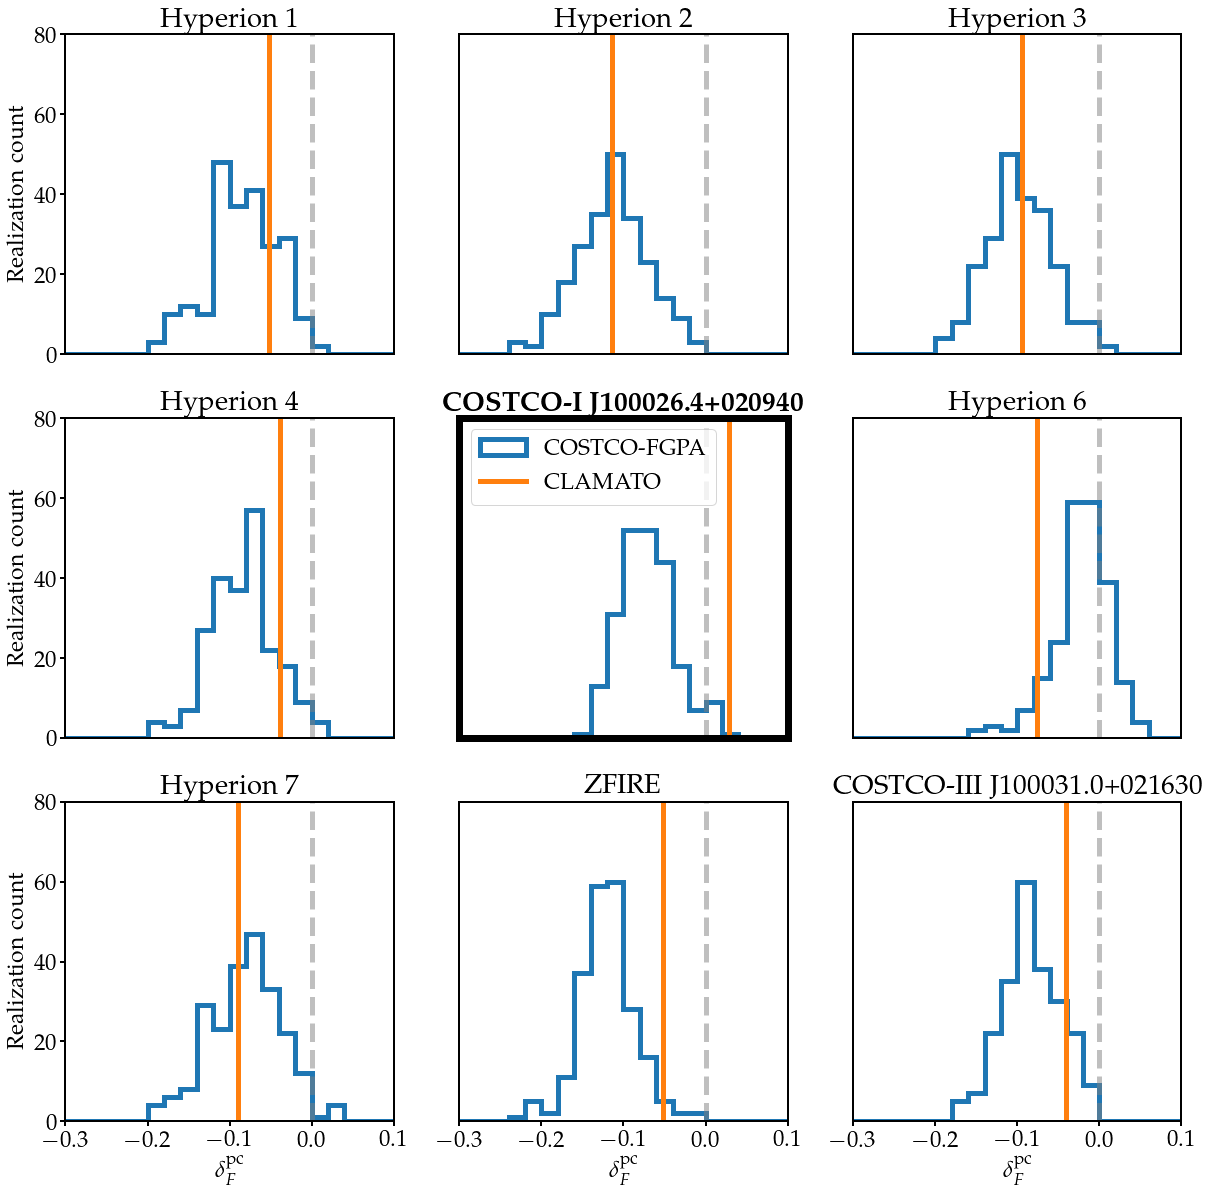

In [30]:
# 15 Mpc, but adjust the range

f = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(20, 20)

for i in range(3):
    for j in range(3):
        index = i*3 + j
        pc = COSTCO_selection.iloc[index]
        

        MOCK = sim_list[index]
        REAL = cla_list[index]

        plt.subplot(grid[7*i:7*i+6, 7*j:7*j+6])

        plt.hist(MOCK, bins = 20, histtype='step', linewidth = 5, density=False, label = 'COSTCO-FGPA', range = (-0.3, 0.1))
        plt.plot([REAL, REAL], [0, 100],  linewidth = 5,  label = 'CLAMATO')
        plt.plot([0, 0], [0, 100],  linewidth = 5,  c = "Grey", alpha = 0.5, linestyle = '--')
        if i == 2:
            plt.xlabel("$\\delta_F^{\mathrm{pc}}$")
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel("Realization count")
        else:
            plt.yticks([])
        if i == 1 and j == 1:
            plt.legend()
            plt.title("\\textbf{"+pc['Name']+"}")

            bwith = 7
            ax = plt.gca()
            ax.spines['bottom'].set_linewidth(bwith)
            ax.spines['left'].set_linewidth(bwith)
            ax.spines['top'].set_linewidth(bwith)
            ax.spines['right'].set_linewidth(bwith)
            
        else:
            plt.title(pc["Name"])
        plt.xlim(-0.3, 0.1)
        plt.ylim(0, 80)
assert radius == 15*u.Mpc
pdf_pages = PdfPages('Detection_Multi_panel_15Mpc.pdf')
pdf_pages.savefig(f, pad_inches = 0)
pdf_pages.close()

In [37]:
x0, y0, z0 = 3550*u.Mpc, -50*u.Mpc, -50*u.Mpc
dl = 2*u.Mpc

dens_field_list = []
# here's some validation: start with reading the density data
dens_list = os.listdir("../Data/lores_density/")
for fn in dens_list:
    dens_m = np.load("../Data/lores_density/"+fn)[:, ::-1, :]
    opdelta = dens_m / np.mean(dens_m)
    opdelta = Field(x0, y0, z0, dl, opdelta)
    opdelta.__setattr__("ID", fn.split('_')[2])
    dens_field_list.append(opdelta)

In [54]:
c = mycoord.orig_to_box(150.11, 2.161, 2.298)
m_15 = sph_mask(opdelta, c, 15*u.Mpc)
m_4_5 = sph_mask(opdelta, c, 4.5*u.Mpc)

In [69]:
entry_list = []
for dens_field in dens_field_list:
    data = copy.deepcopy(dens_field.field_data)
    data[~m_15] = np.nan
    pos = np.nanargmax(data)
    pos = np.unravel_index(pos, data.shape)
    if m_4_5[pos]:
        entry_list.append(dens_field.ID)

In [93]:
# read data
rec_sim_list_selected = []
for fn in os.listdir(data_path+"rec_field_sim/"):
    if fn[-3:] == 'bin' and fn.split('_')[3] in entry_list:
        rec_sim_list_selected.append('../Data/rec_field_sim/'+fn)

In [94]:
R_tophat = 4 * u.Mpc

# clamato
clamato_path = '../Data/CLAMATO/map_2020_v0.bin'
delta_clm_real = np.fromfile(clamato_path, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_clm_real = delta_clm_real[::1,::-1,::1] 
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
CLAMATO_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_clm_real)
res = CLAMATO_field.smooth_tophat_fft(R_tophat)


# mock
mock_field_list = []
for i, fn in enumerate(rec_sim_list_selected):
    delta_rec_mock = np.fromfile(fn, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
    delta_rec_mock = delta_rec_mock[::1,::-1,::1] 

    x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
    rec_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec_mock)
    res = rec_field.smooth_tophat_fft(R_tophat)

    mock_field_list.append(rec_field)

# takes ~ 6 / 25 min to convolve !!! (for convolve in real space, ~ 50 / 200realizations)
# 20 / 100 sec with FFT (expected)

In [96]:
COSTCO_meta = pd.read_csv('../Catalogs/COSTCO_metadata.csv')
COSTCO_selection = COSTCO_meta.iloc[[10]]

In [97]:
radius = 4.5*u.Mpc
sim_list = []
cla_list = []
for gal in COSTCO_selection.iloc:
    c = mycoord.orig_to_box(gal['RA'], gal['DE'], gal['z_obs'])
    m = sph_mask(CLAMATO_field, c, radius)
    sim_mean_list = []
    for r in mock_field_list:
        data = copy.deepcopy(r.field_data)
        data[~m] = np.nan
        avg = np.nanmean(data)
        sim_mean_list.append(avg)
    data = copy.deepcopy(CLAMATO_field.field_data)
    data[~m] = np.nan
    avg = np.nanmean(data)
    
    sim_list.append(sim_mean_list)
    cla_list.append(avg)

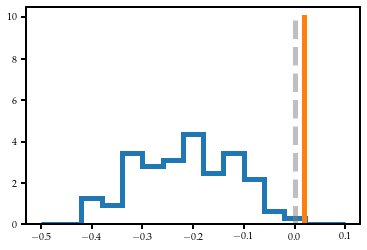

In [102]:
MOCK = sim_list[0]
REAL = cla_list[0]
plt.hist(MOCK, bins = 15, histtype='step', linewidth = 5, density=True, label = 'COSTCO-FGPA', range = (-0.5, 0.1))
plt.plot([REAL, REAL], [0, 10],  linewidth = 5,  label = 'CLAMATO')
plt.plot([0, 0], [0, 10],  linewidth = 5,  c = "Grey", alpha = 0.5, linestyle = '--')

In [105]:
np.sum(MOCK < REAL)

80